In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import date, datetime, timedelta
sns.set_theme(style="ticks")
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'

# parameters

In [2]:
yeari, yearf = '2024', '2024'
weeki, weekf = '18', '31'

In [3]:
di = datetime.strptime(f'{yeari}-{weeki}-1', "%Y-%W-%w").date()
df = datetime.strptime(f'{yearf}-{weekf}-1', "%Y-%W-%w").date() + timedelta(6)
ds = [di+timedelta(dt) for dt in range((df-di).days+1)]
daylist = ds
print(di, 'until', df)

2024-04-29 until 2024-08-04


In [4]:
cdef = 'tl7_10m'# 'tl5_10m' 'tl6_10m' 'tl7_10m' 'tl8_10m' 'tl8_60m'
cdef_alt = '16m_10min'# tl5: 62 ... tl7: 16   tl8: 8

# load data

In [5]:
# load stadium meta data
stadname_data = pd.read_csv('data/metadata/stadname_data.csv')
aid2name = {aid: name for aid, name in zip(stadname_data.area_id, stadname_data.area_name)}

aid2city = {aid: city for aid, city in sorted({
    1: 'München',
    2: 'Berlin',
    3: 'Leipzig',
    4: 'Frankfurt am Main',
    10: 'Dortmund',
    11: 'Stuttgart',
    15: 'Köln',
    24: 'Düsseldorf',
    25: 'Hamburg',
    28: 'Gelsenkirchen',

    16: 'Berlin',
    29: 'Hamburg',
    41: 'München',
    64: 'Frankfurt am Main',
}.items(), key=lambda item: item[1])}
city2aid = {city: aid for aid, city in [(aid, city) for aid, city in aid2city.items()][::-1]}

In [6]:
# load mass event data
match_data = pd.read_csv('data/metadata/event_data.csv')
match_data['day'] = [d.date() for d in pd.to_datetime(match_data.day)]

# analyses

In [7]:
# n_c Germany: load total contact numbers for Germany
data_germany_b = pd.read_csv(f'data/fig2/ncontacts_germany_{cdef}.csv')
data_germany_b['day'] = [d.date() for d in pd.to_datetime(data_germany_b.day)]

# n_c cities: load total contact numbers numbers for cities
data_b = pd.read_csv(f'data/fig2/ncontacts_cities_{cdef}.csv')
data_b['day'] = [d.date() for d in pd.to_datetime(data_b.day)]

In [8]:
def convert_labels(match):
    if 'BLiga' in match:
        new = 'BLiga'
    elif 'S25' in match or 'friendly' in match or 'Am.' in match or 'HipHop' in match:
        new = ''
    else:
        new = match
    return new
match_data['match'] = match_data.match.apply(convert_labels)

In [9]:
vac_data = [
    ['Berlin', date(2024,7,18), date(2024,8,30)],
    ['Dortmund', date(2024,7,8), date(2024,8,20)],
    ['Düsseldorf', date(2024,7,8), date(2024,8,20)],
    ['Frankfurt am Main', date(2024,7,15), date(2024,8,23)],
    ['Gelsenkirchen', date(2024,7,8), date(2024,8,20)],
    ['Hamburg', date(2024,7,18), date(2024,8,28)],
    ['Köln', date(2024,7,8), date(2024,8,20)],
    ['Leipzig', date(2024,6,20), date(2024,8,2)],
    ['München', date(2024,7,29), date(2024,9,9)],
    ['Stuttgart', date(2024,7,25), date(2024,9,7)],
]
vac_data = pd.DataFrame(vac_data, columns=['city','day_start','day_end'])
vac_data

,city,day_start,day_end
0,Berlin,2024-07-18,2024-08-30
1,Dortmund,2024-07-08,2024-08-20
2,Düsseldorf,2024-07-08,2024-08-20
3,Frankfurt am Main,2024-07-15,2024-08-23
4,Gelsenkirchen,2024-07-08,2024-08-20
5,Hamburg,2024-07-18,2024-08-28
6,Köln,2024-07-08,2024-08-20
7,Leipzig,2024-06-20,2024-08-02
8,München,2024-07-29,2024-09-09
9,Stuttgart,2024-07-25,2024-09-07


## cities

In [10]:
data_here = data_b.copy(deep=True)
data_here = data_here.drop(columns=['resolution'])
data_here['wd'] = [d.weekday() for d in data_here.day]

# baseline = number contacts in city without stadiums by weekday, averaged over many weeks
baseline_nu = pd.DataFrame(data_here[data_here.event.isna()].groupby(['city','wd']).contacts_nonunique.mean()).rename(columns={'contacts_nonunique':'baseline_nonunique'}).reset_index()
data_here = data_here.merge(baseline_nu, on=['city','wd'])
baseline_u = pd.DataFrame(data_here[data_here.event.isna()].groupby(['city','wd']).contacts_unique.mean()).rename(columns={'contacts_unique':'baseline_unique'}).reset_index()
data_here = data_here.merge(baseline_u, on=['city','wd'])

data_here2, data_here3 = data_here.copy(deep=True), data_here.copy(deep=True)
data_here2['to_baseline_nonunique'] = data_here.contacts_nonunique / data_here.baseline_nonunique
data_here2['to_baseline_unique'] = data_here.contacts_unique / data_here.baseline_unique
data_here2['with_stadiums'] = False
data_here3['to_baseline_nonunique'] = (data_here.contacts_nonunique + data_here.contacts_nonunique_stadium) / data_here.baseline_nonunique
data_here3['to_baseline_unique'] = (data_here.contacts_unique + data_here.contacts_unique_stadium) / data_here.baseline_unique
data_here3['with_stadiums'] = True
data_here4 = pd.concat([data_here2, data_here3], ignore_index=True)
data_here4

,city,day,event,contacts_nonunique,contacts_nonunique_stadium,contacts_unique,contacts_unique_stadium,wd,baseline_nonunique,baseline_unique,to_baseline_nonunique,to_baseline_unique,with_stadiums
0,Berlin,2024-04-29,NaN,6086,0,2624,0,0,4977.230769,2465.384615,1.222768,1.064337,False
1,Berlin,2024-05-06,NaN,5074,0,2546,0,0,4977.230769,2465.384615,1.019442,1.032699,False
2,Berlin,2024-05-13,NaN,4932,0,2580,0,0,4977.230769,2465.384615,0.990912,1.046490,False
3,Berlin,2024-05-20,NaN,2704,0,1240,0,0,4977.230769,2465.384615,0.543274,0.502964,False
4,Berlin,2024-05-27,NaN,6616,0,2756,0,0,4977.230769,2465.384615,1.329253,1.117878,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,Stuttgart,2024-07-07,NaN,388,0,222,0,6,438.000000,244.363636,0.885845,0.908482,True
1966,Stuttgart,2024-07-14,NaN,490,0,218,0,6,438.000000,244.363636,1.118721,0.892113,True
1967,Stuttgart,2024-07-21,NaN,422,0,286,0,6,438.000000,244.363636,0.963470,1.170387,True
1968,Stuttgart,2024-07-28,NaN,574,0,298,0,6,438.000000,244.363636,1.310502,1.219494,True


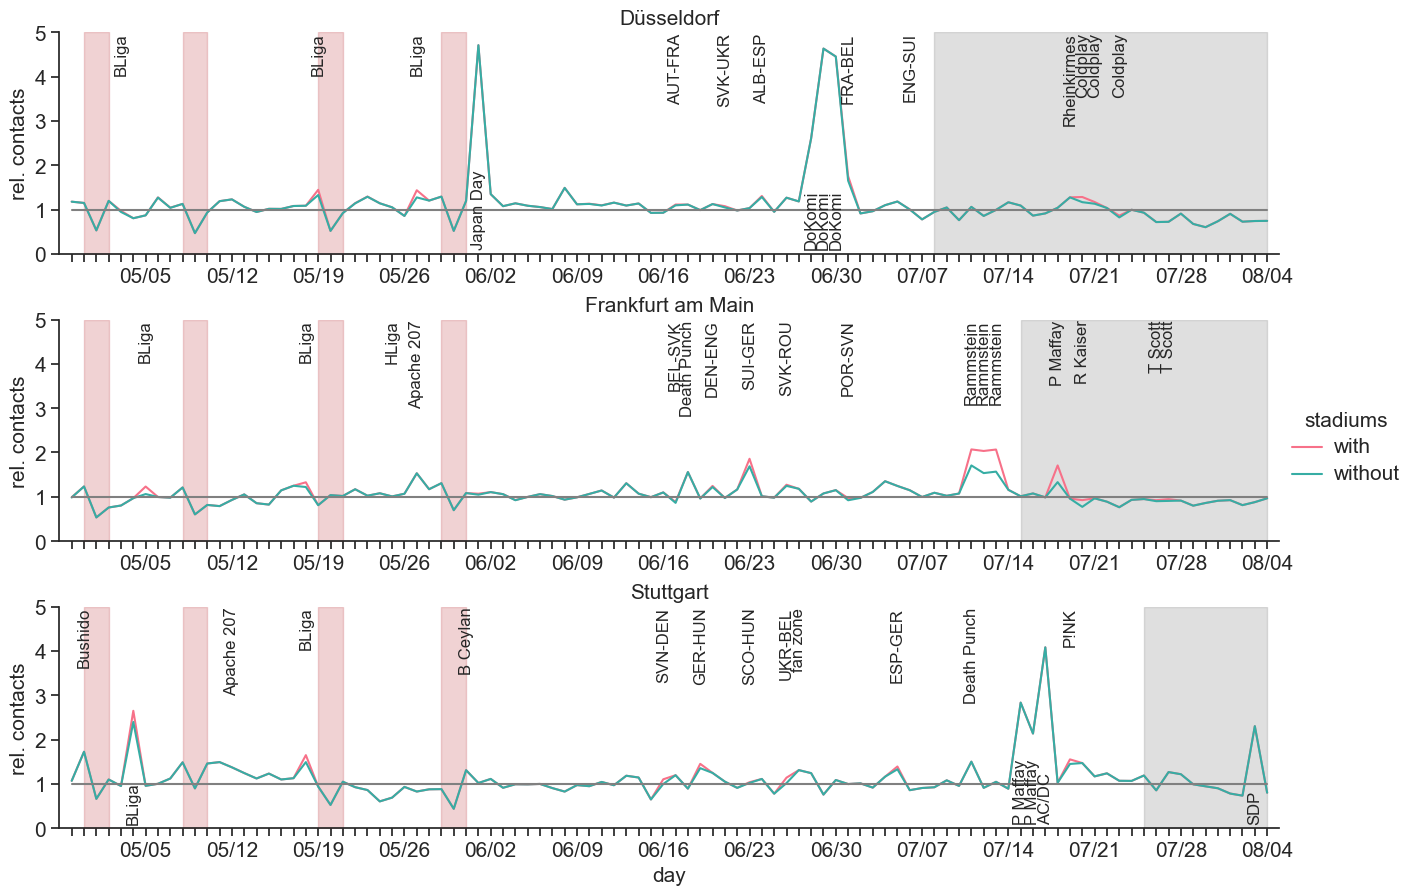

In [11]:
# baseline comparison only for unique contacts and only for 3 selected cities
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.husl_palette(2)#sns.color_palette("rocket_r")

city_list = [city for city in sorted(set(list(aid2city.values()))) if city in ['Düsseldorf','Frankfurt am Main','Stuttgart']] #set(data_here.city)

# Plot the lines on two facets
g = sns.relplot(
    data=data_here4[data_here4.city.isin(city_list)],
    x="day", y="to_baseline_unique",
    hue="with_stadiums", hue_order=[True,False],
    row="city", row_order=city_list,# size="choice",# col="align",
    kind="line", palette=palette,# size_order=[False, True], 
    height=3, aspect=6.5/1.5, facet_kws=dict(sharex=False),
)

ylimup = 5.
axes = g.axes
holis = [date(2024,5,1), date(2024,5,9), date(2024,5,20)]
for ax_row, city in zip(axes, city_list):
    for ax in ax_row:
        ax.tick_params(labelsize=15)
        ax.set_ylabel('rel. contacts', fontsize=15)
        ax.plot([data_here.day.min(), data_here.day.max()], [1,1], c='gray')
        ax.set_title(city, fontsize=15)
        ax.set_xticks(list(set(data_here.day)))
        ax.set_xticklabels([str(d.month).zfill(2)+'/'+str(d.day).zfill(2) if d.weekday()==6 else '' for d in list(set(data_here.day))])#, rotation=90)
        #lower = set(data_here.city)
        #ax.fill_between([data_here.day.min(), data_here.day.max()], [1,1]
        matches_here = match_data[match_data.city==city]
        for day, match in zip(matches_here.day, matches_here.match):
            if day >= data_here4.day.min() and day <= data_here4.day.max():
                if data_here4[(data_here4.day==day) & (data_here4.city==city)].to_baseline_unique.max() < 2.1:
                    ax.text(day, ylimup, match, rotation=90, ha='center', va='top', fontsize=12)
                else:
                    ax.text(day, 0.1, match, rotation=90, ha='center', va='bottom', fontsize=12)
        day_start = vac_data[vac_data.city==city].day_start.iloc[0]
        day_end = min(vac_data[vac_data.city==city].day_end.iloc[0], data_here4.day.max())
        if day_end > day_start:
            ax.fill_between([day_start, day_end], [0]*2, [ylimup]*2, color='gray', alpha=.25)
        ax.set_ylim([0., ylimup])
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_xlim([di-timedelta(1), df+timedelta(1)])

        for holi in holis:
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [ylimup]*2, color='C3', alpha=.25)
        if city in ['Frankfurt am Main','München','Köln','Düsseldorf','Dortmund','Gelsenkirchen','Stuttgart']:
            holi = date(2024,5,30)
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [ylimup]*2, color='C3', alpha=.25)
ax.set_xlabel('day', fontsize=15)

lg = g._legend
lg.set_title('stadiums')
lg.get_title().set_fontsize(15)
for tx in lg.texts:
    tx.set_fontsize(15)
    if tx.get_text() == 'True':
        tx.set_text('with')
    elif tx.get_text() == 'False':
        tx.set_text('without')

plt.savefig(f'plots/fig2/contacts_baseline_cmp_unique_3cities.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig2/contacts_baseline_cmp_unique_3cities.pdf', bbox_inches='tight')
plt.show()

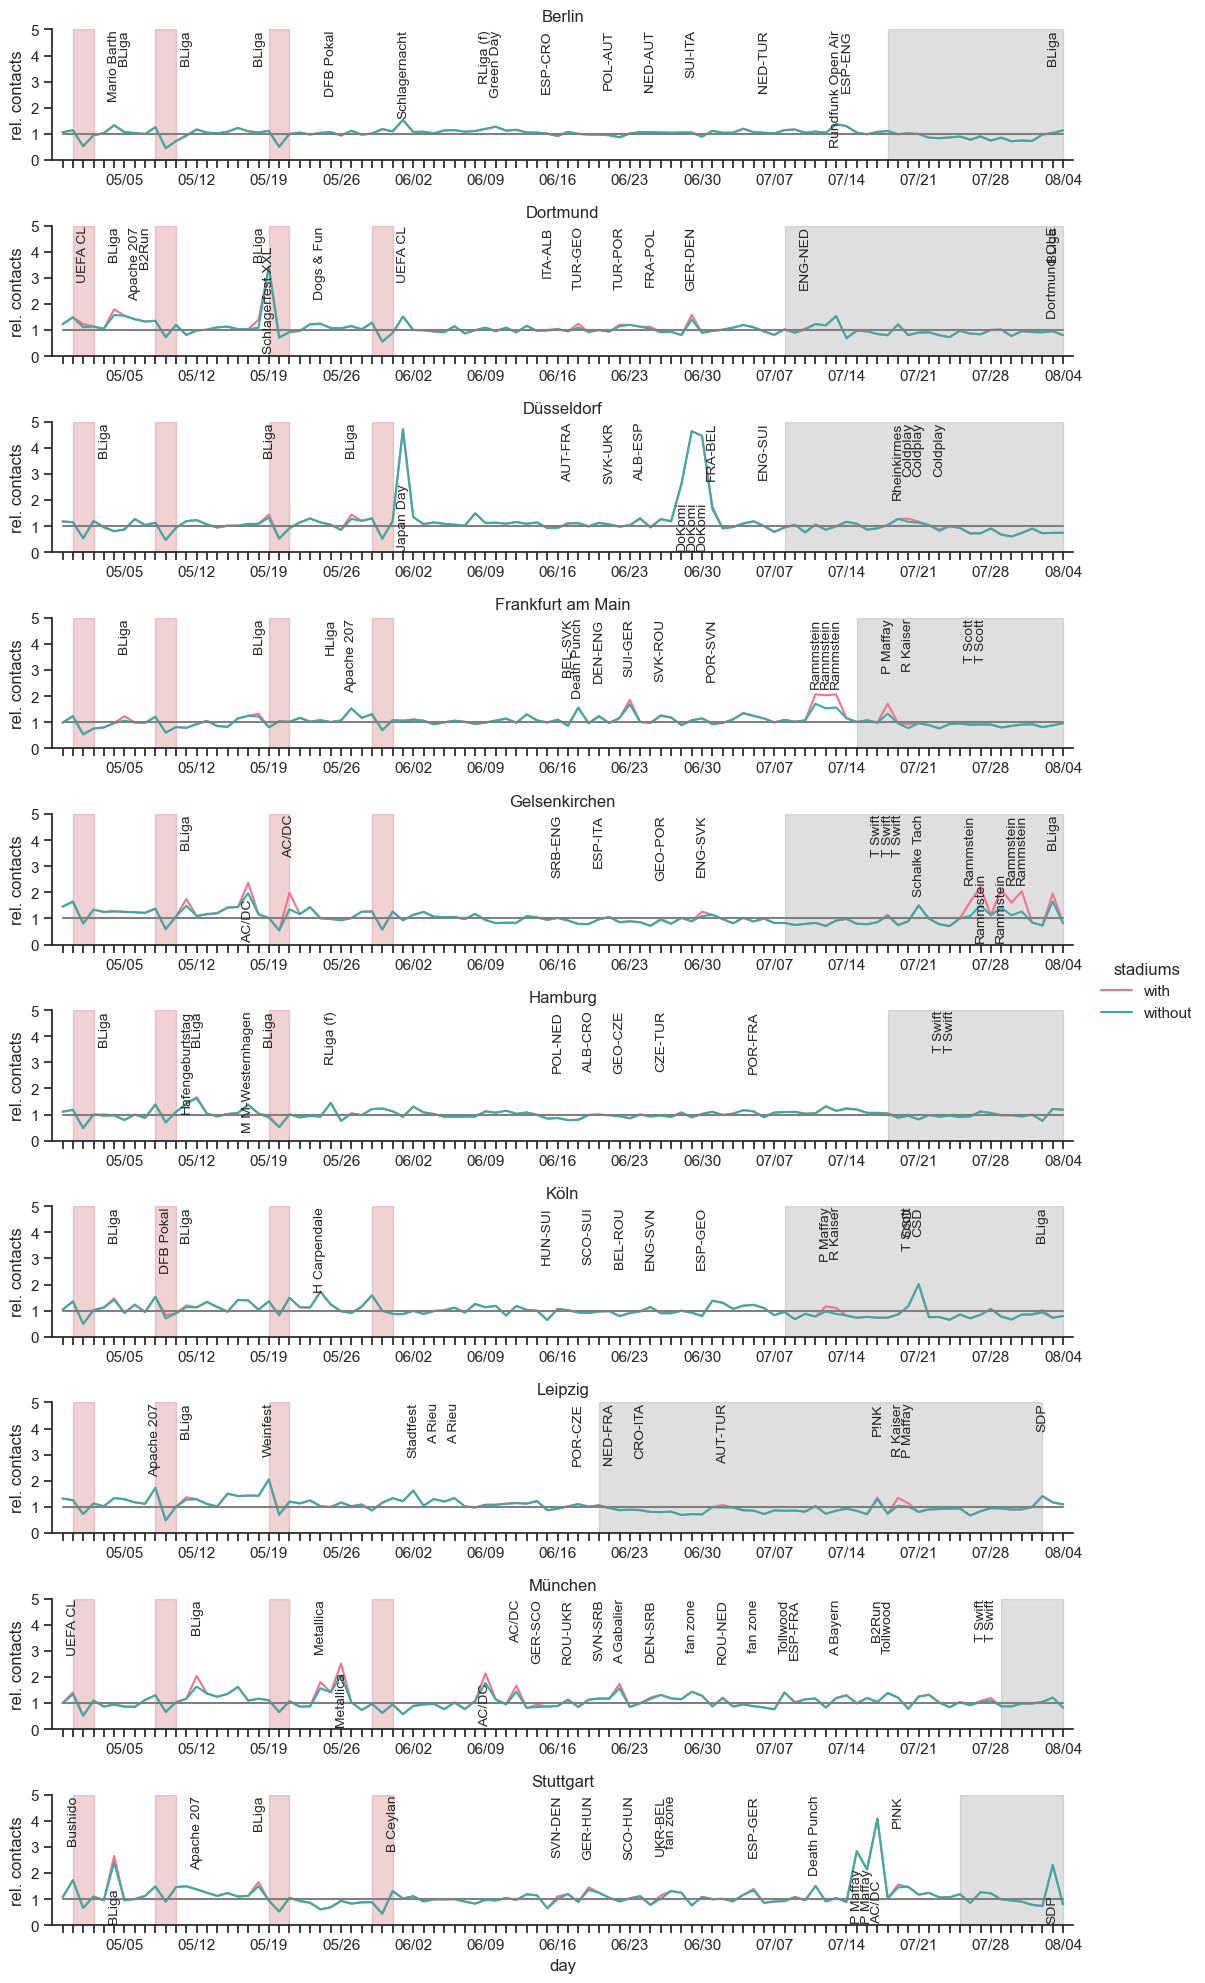

In [12]:
# baseline comparison only for unique contacts
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.husl_palette(2)#sns.color_palette("rocket_r")

city_list = sorted(set(list(aid2city.values()))) #set(data_here.city)

# Plot the lines on two facets
g = sns.relplot(
    data=data_here4,
    x="day", y="to_baseline_unique",
    hue="with_stadiums", hue_order=[True,False],
    row="city", row_order=city_list,# size="choice",# col="align",
    kind="line", palette=palette,# size_order=[False, True], 
    height=2, aspect=5.5, facet_kws=dict(sharex=False),
)

ylimup = 5.#3.75
axes = g.axes
holis = [date(2024,5,1), date(2024,5,9), date(2024,5,20)]
for ax_row, city in zip(axes, city_list):
    for ax in ax_row:
        ax.set_ylabel('rel. contacts')
        ax.plot([data_here.day.min(), data_here.day.max()], [1,1], c='gray')
        ax.set_title(city)
        ax.set_xticks(list(set(data_here.day)))
        ax.set_xticklabels([str(d.month).zfill(2)+'/'+str(d.day).zfill(2) if d.weekday()==6 else '' for d in list(set(data_here.day))])#, rotation=90)
        #lower = set(data_here.city)
        #ax.fill_between([data_here.day.min(), data_here.day.max()], [1,1]
        matches_here = match_data[match_data.city==city]
        for day, match in zip(matches_here.day, matches_here.match):
            if day >= data_here4.day.min() and day <= data_here4.day.max():
                if data_here4[(data_here4.day==day) & (data_here4.city==city)].to_baseline_unique.max() < 2.1:
                    ax.text(day, ylimup, match, rotation=90, ha='center', va='top', fontsize=10)
                else:
                    ax.text(day, 0.1, match, rotation=90, ha='center', va='bottom', fontsize=10)
        day_start = vac_data[vac_data.city==city].day_start.iloc[0]
        day_end = min(vac_data[vac_data.city==city].day_end.iloc[0], data_here4.day.max())
        if day_end > day_start:
            ax.fill_between([day_start, day_end], [0]*2, [ylimup]*2, color='gray', alpha=.25)
        ax.set_ylim([0., ylimup])
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_xlim([di-timedelta(1), df+timedelta(1)])

        for holi in holis:
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [ylimup]*2, color='C3', alpha=.25)
        if city in ['Frankfurt am Main','München','Köln','Düsseldorf','Dortmund','Gelsenkirchen','Stuttgart']:
            holi = date(2024,5,30)
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [ylimup]*2, color='C3', alpha=.25)

lg = g._legend
lg.set_title('stadiums')
for tx in lg.texts:
    if tx.get_text() == 'True':
        tx.set_text('with')
    elif tx.get_text() == 'False':
        tx.set_text('without')

plt.savefig(f'plots/figs1/contacts_baseline_cmp_unique.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/figs1/contacts_baseline_cmp_unique.pdf', bbox_inches='tight')
plt.show()

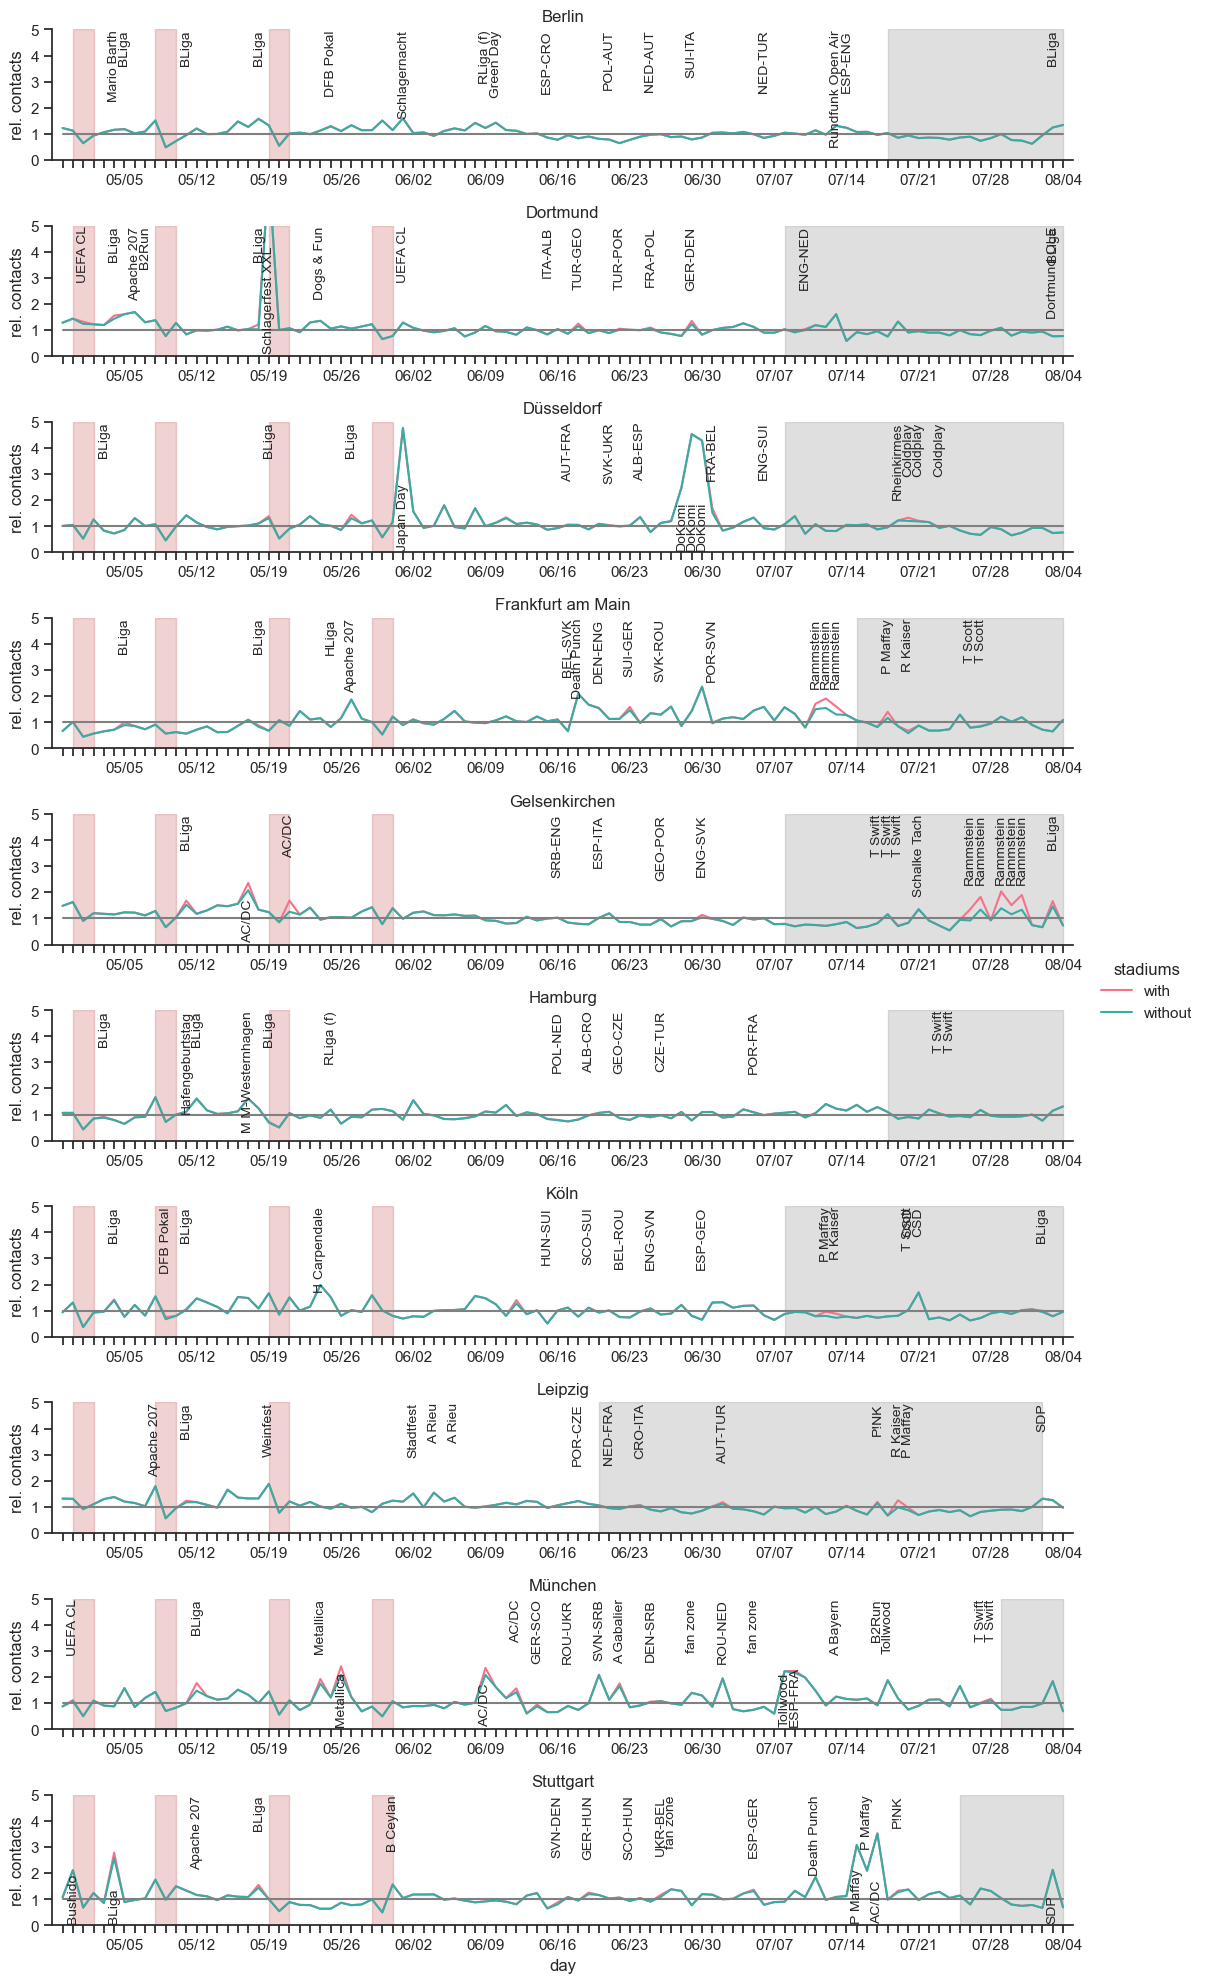

In [13]:
# baseline comparison only for non-unique contacts
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.husl_palette(2)#sns.color_palette("rocket_r")

city_list = sorted(set(list(aid2city.values()))) #set(data_here.city)

# Plot the lines on two facets
g = sns.relplot(
    data=data_here4,
    x="day", y="to_baseline_nonunique",
    hue="with_stadiums", hue_order=[True,False],
    row="city", row_order=city_list,# size="choice",# col="align",
    kind="line", palette=palette,# size_order=[False, True], 
    height=2, aspect=5.5, facet_kws=dict(sharex=False),
)

ylimup = 5.#3.75
axes = g.axes
holis = [date(2024,5,1), date(2024,5,9), date(2024,5,20)]
for ax_row, city in zip(axes, city_list):
    for ax in ax_row:
        ax.set_ylabel('rel. contacts')
        ax.plot([data_here.day.min(), data_here.day.max()], [1,1], c='gray')
        ax.set_title(city)
        ax.set_xticks(list(set(data_here.day)))
        ax.set_xticklabels([str(d.month).zfill(2)+'/'+str(d.day).zfill(2) if d.weekday()==6 else '' for d in list(set(data_here.day))])#, rotation=90)
        #lower = set(data_here.city)
        #ax.fill_between([data_here.day.min(), data_here.day.max()], [1,1]
        matches_here = match_data[match_data.city==city]
        for day, match in zip(matches_here.day, matches_here.match):
            if day >= data_here4.day.min() and day <= data_here4.day.max():
                if data_here4[(data_here4.day==day) & (data_here4.city==city)].to_baseline_nonunique.max() < 2.1:
                    ax.text(day, ylimup, match, rotation=90, ha='center', va='top', fontsize=10)
                else:
                    ax.text(day, 0.1, match, rotation=90, ha='center', va='bottom', fontsize=10)
        day_start = vac_data[vac_data.city==city].day_start.iloc[0]
        day_end = min(vac_data[vac_data.city==city].day_end.iloc[0], data_here4.day.max())
        if day_end > day_start:
            ax.fill_between([day_start, day_end], [0]*2, [ylimup]*2, color='gray', alpha=.25)
        ax.set_ylim([0., ylimup])
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_xlim([di-timedelta(1), df+timedelta(1)])

        for holi in holis:
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [ylimup]*2, color='C3', alpha=.25)
        if city in ['Frankfurt am Main','München','Köln','Düsseldorf','Dortmund','Gelsenkirchen','Stuttgart']:
            holi = date(2024,5,30)
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [ylimup]*2, color='C3', alpha=.25)

lg = g._legend
lg.set_title('stadiums')
for tx in lg.texts:
    if tx.get_text() == 'True':
        tx.set_text('with')
    elif tx.get_text() == 'False':
        tx.set_text('without')

plt.savefig(f'plots/figs1/contacts_baseline_cmp_nonunique.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/figs1/contacts_baseline_cmp_nonunique.pdf', bbox_inches='tight')
plt.show()

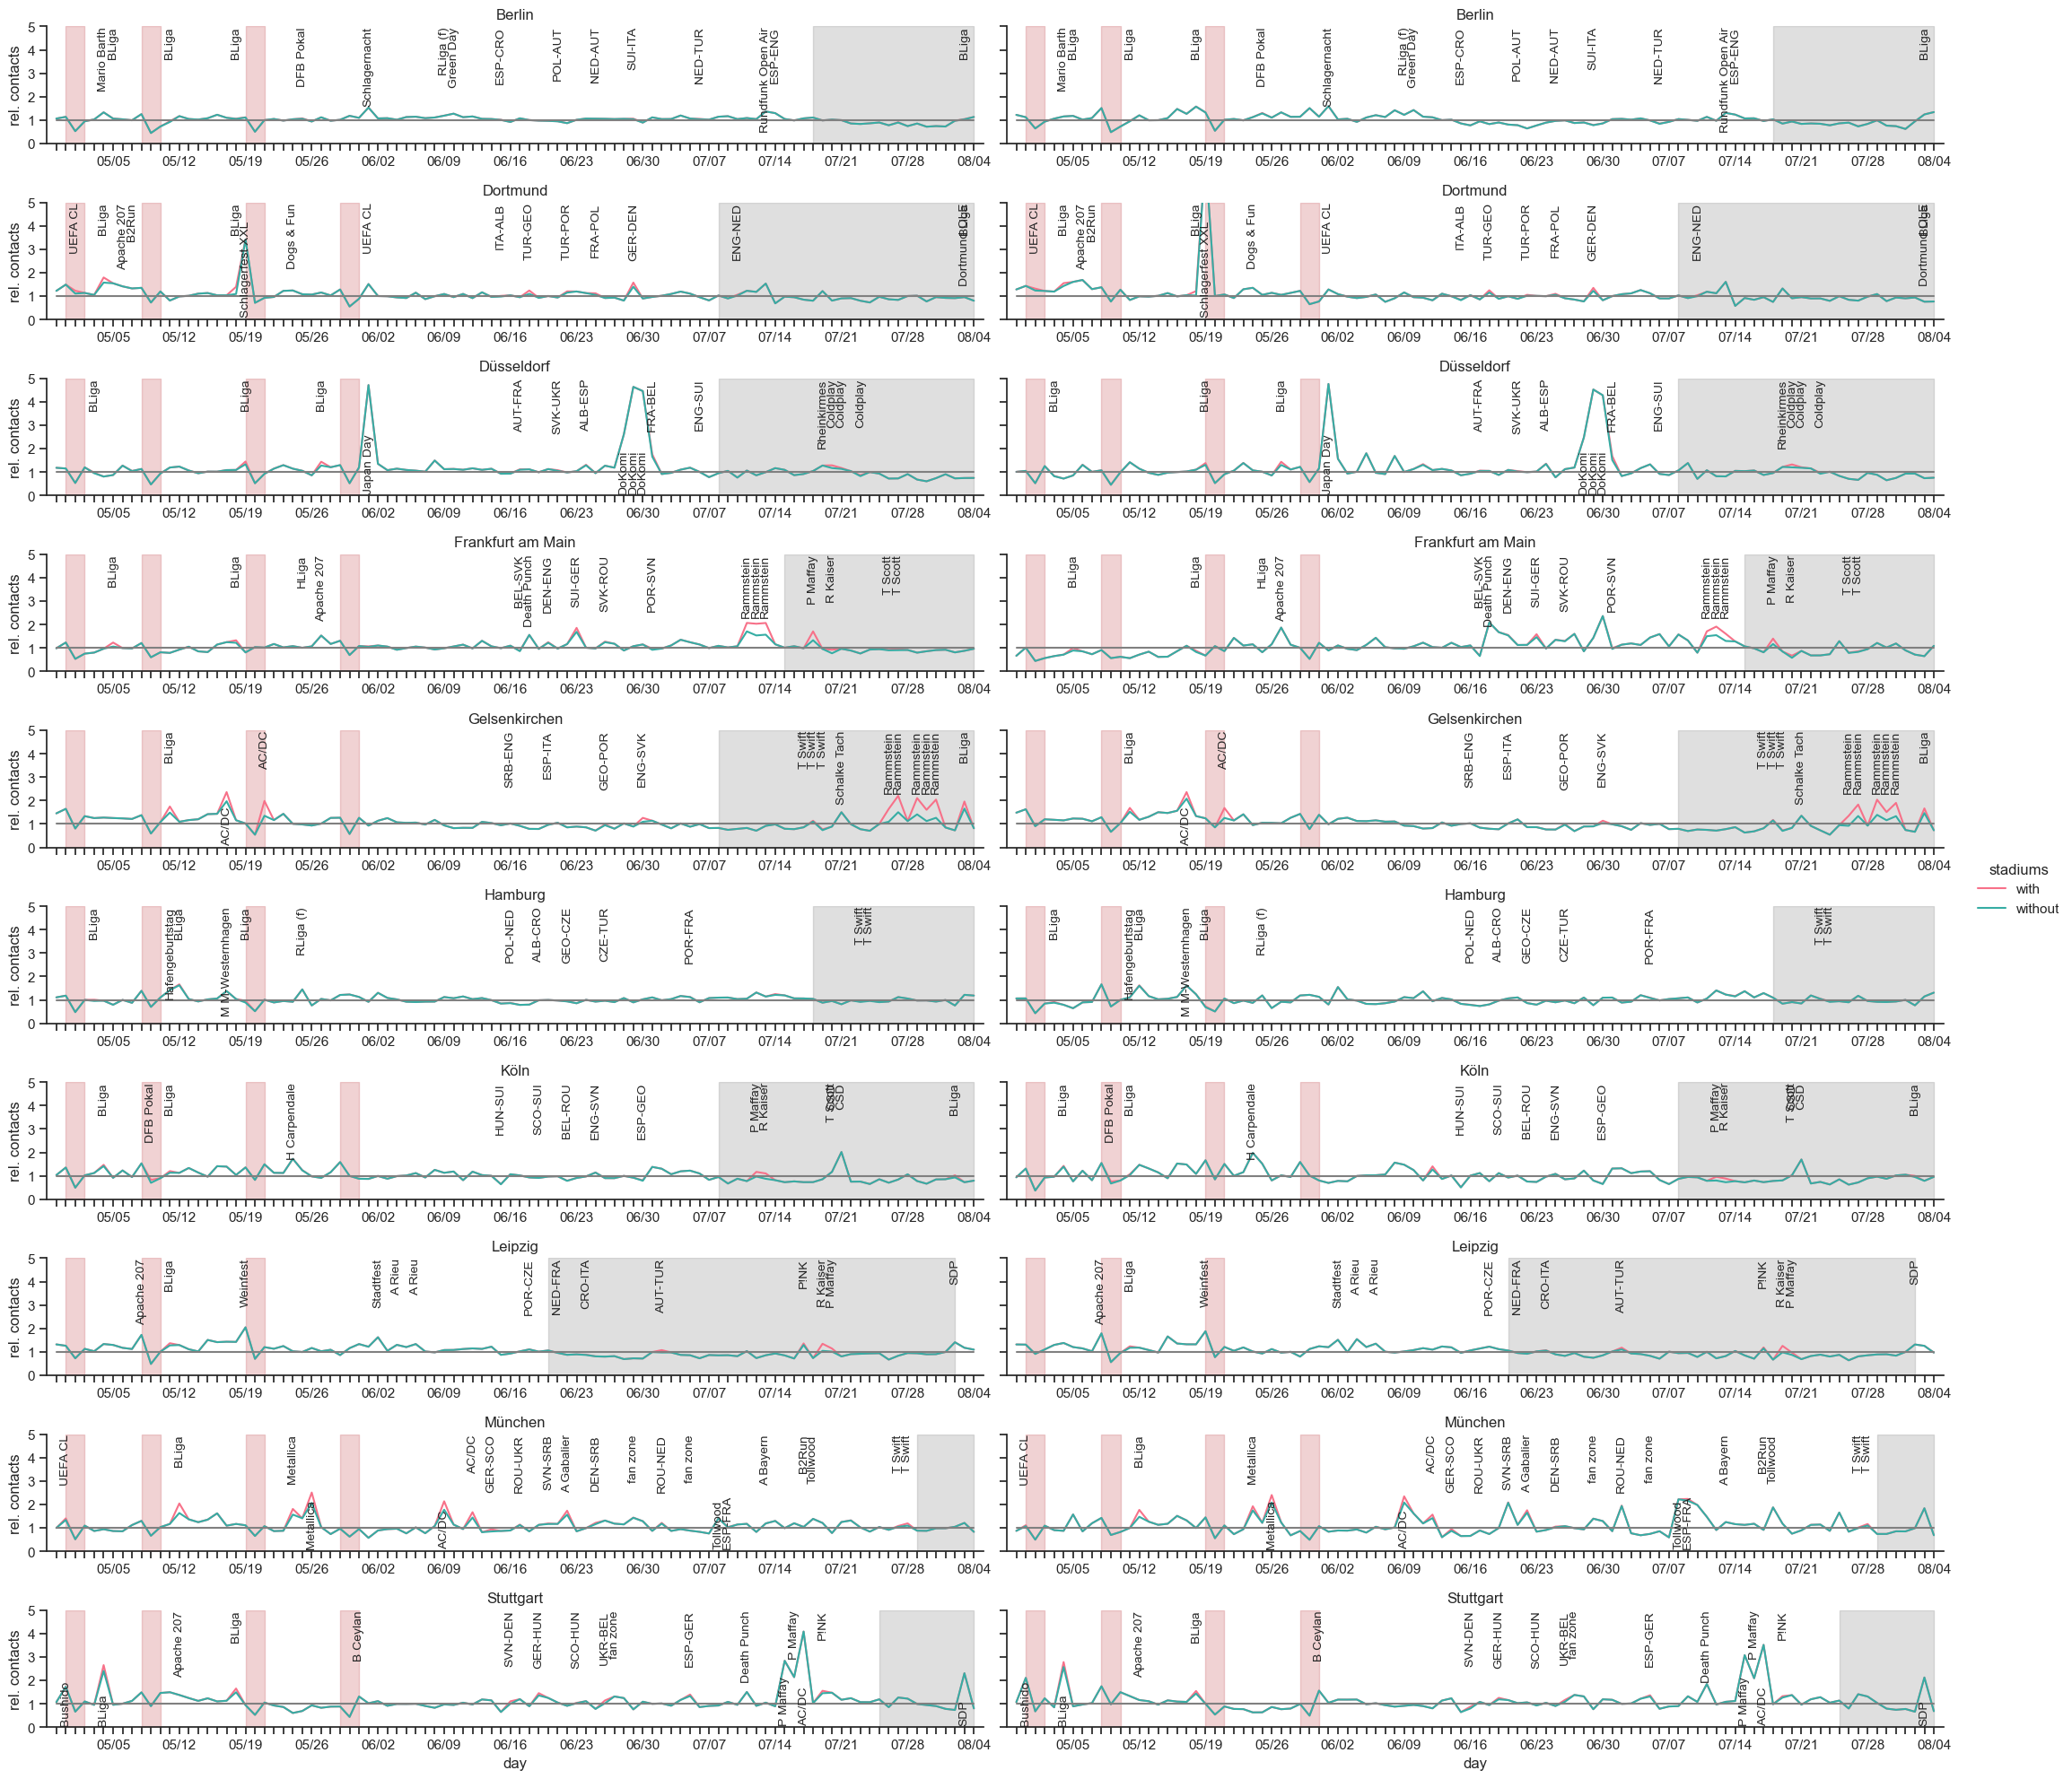

In [14]:
concat1 = data_here4[['day','city','with_stadiums','to_baseline_nonunique']].rename(columns={'to_baseline_nonunique':'to_baseline'})
concat1['weighted'] = True
concat2 = data_here4[['day','city','with_stadiums','to_baseline_unique']].rename(columns={'to_baseline_unique':'to_baseline'})
concat2['weighted'] = False
data_here5 = pd.concat([concat1, concat2])
data_here5

# baseline comparison for both unique and non-unique contacts together
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.husl_palette(2)#sns.color_palette("rocket_r")

city_list = sorted(set(list(aid2city.values()))) #set(data_here.city)

# Plot the lines on two facets
g = sns.relplot(
    data=data_here5,
    x="day", y="to_baseline",
    hue="with_stadiums", hue_order=[True,False],
    row="city", row_order=city_list,# size="choice",# col="align",
    col="weighted", col_order=[False,True],
    kind="line", palette=palette,# size_order=[False, True], 
    height=2, aspect=5.5, facet_kws=dict(sharex=False),
)

ylimup = 5.#3.75
axes = g.axes
holis = [date(2024,5,1), date(2024,5,9), date(2024,5,20)]
for ax_row, city in zip(axes, city_list):
    for ax in ax_row:
        ax.set_ylabel('rel. contacts')
        ax.plot([data_here.day.min(), data_here.day.max()], [1,1], c='gray')
        ax.set_title(city)
        ax.set_xticks(list(set(data_here.day)))
        ax.set_xticklabels([str(d.month).zfill(2)+'/'+str(d.day).zfill(2) if d.weekday()==6 else '' for d in list(set(data_here.day))])#, rotation=90)
        #lower = set(data_here.city)
        #ax.fill_between([data_here.day.min(), data_here.day.max()], [1,1]
        matches_here = match_data[match_data.city==city]
        for day, match in zip(matches_here.day, matches_here.match):
            if day >= data_here4.day.min() and day <= data_here4.day.max():
                if data_here4[(data_here4.day==day) & (data_here4.city==city)].to_baseline_nonunique.max() < 2.1:
                    ax.text(day, ylimup, match, rotation=90, ha='center', va='top', fontsize=10)
                else:
                    ax.text(day, 0.1, match, rotation=90, ha='center', va='bottom', fontsize=10)
        day_start = vac_data[vac_data.city==city].day_start.iloc[0]
        day_end = min(vac_data[vac_data.city==city].day_end.iloc[0], data_here4.day.max())
        if day_end > day_start:
            ax.fill_between([day_start, day_end], [0]*2, [ylimup]*2, color='gray', alpha=.25)
        ax.set_ylim([0., ylimup])
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_xlim([di-timedelta(1), df+timedelta(1)])

        for holi in holis:
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [ylimup]*2, color='C3', alpha=.25)
        if city in ['Frankfurt am Main','München','Köln','Düsseldorf','Dortmund','Gelsenkirchen','Stuttgart']:
            holi = date(2024,5,30)
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [ylimup]*2, color='C3', alpha=.25)

lg = g._legend
lg.set_title('stadiums')
for tx in lg.texts:
    if tx.get_text() == 'True':
        tx.set_text('with')
    elif tx.get_text() == 'False':
        tx.set_text('without')

plt.savefig(f'plots/figs1/contacts_baseline_cmp_uniquenonunique.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/figs1/contacts_baseline_cmp_uniquenonunique.pdf', bbox_inches='tight')
plt.show()

## Germany

In [21]:
data_here = data_germany_b.copy(deep=True)
data_here = data_here.drop(columns=['resolution'])
data_here['wd'] = [d.weekday() for d in data_here.day]

# baseline = number contacts in city without stadiums by weekday, averaged over many weeks
baseline_nu = pd.DataFrame(data_here.groupby(['wd']).contacts_nonunique.mean()).rename(columns={'contacts_nonunique':'baseline_nonunique'}).reset_index()
data_here = data_here.merge(baseline_nu, on=['wd'])
baseline_u = pd.DataFrame(data_here.groupby(['wd']).contacts_unique.mean()).rename(columns={'contacts_unique':'baseline_unique'}).reset_index()
data_here = data_here.merge(baseline_u, on=['wd'])

data_here2, data_here3 = data_here.copy(deep=True), data_here.copy(deep=True)
data_here2['to_baseline_nonunique'] = data_here.contacts_nonunique / data_here.baseline_nonunique
data_here2['to_baseline_unique'] = data_here.contacts_unique / data_here.baseline_unique
data_here2['with_stadiums'] = False
data_here3['to_baseline_nonunique'] = (data_here.contacts_nonunique + data_here.contacts_nonunique_stadium) / data_here.baseline_nonunique
data_here3['to_baseline_unique'] = (data_here.contacts_unique + data_here.contacts_unique_stadium) / data_here.baseline_unique
data_here3['with_stadiums'] = True
data_here4 = pd.concat([data_here2, data_here3], ignore_index=True)
data_here4

,day,contacts_nonunique,contacts_nonunique_stadium,contacts_unique,contacts_unique_stadium,wd,baseline_nonunique,baseline_unique,to_baseline_nonunique,to_baseline_unique,with_stadiums
0,2024-04-29,117292,4,84826,4,0,106702.142857,77550.000000,1.099247,1.093823,False
1,2024-05-06,112580,6,80890,2,0,106702.142857,77550.000000,1.055087,1.043069,False
2,2024-05-13,108918,2,79006,2,0,106702.142857,77550.000000,1.020767,1.018775,False
3,2024-05-20,103166,6,69746,6,0,106702.142857,77550.000000,0.966860,0.899368,False
4,2024-05-27,106628,100,78662,92,0,106702.142857,77550.000000,0.999305,1.014339,False
...,...,...,...,...,...,...,...,...,...,...,...
191,2024-07-07,107280,8,74408,8,6,106270.000000,72696.857143,1.009579,1.023648,True
192,2024-07-14,107200,44,76502,44,6,106270.000000,72696.857143,1.009165,1.052948,True
193,2024-07-21,104566,114,72756,108,6,106270.000000,72696.857143,0.985038,1.002299,True
194,2024-07-28,100652,36,71964,32,6,106270.000000,72696.857143,0.947473,0.990359,True


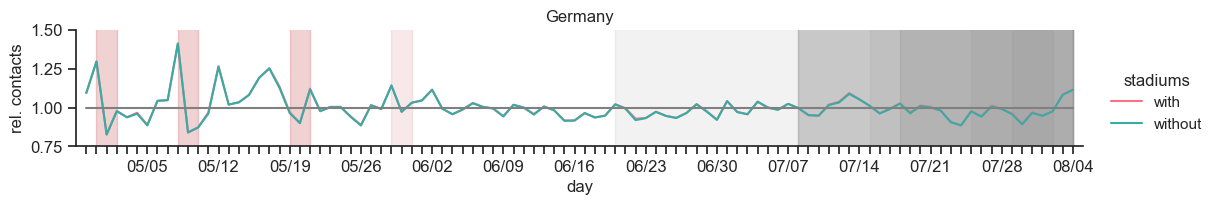

In [22]:
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.husl_palette(2)#sns.color_palette("rocket_r")

city_list = sorted(set(list(aid2city.values()))) #set(data_here.city)

# Plot the lines on two facets
g = sns.relplot(
    data=data_here4,
    x="day", y="to_baseline_unique",
    hue="with_stadiums", hue_order=[True,False],
    kind="line", palette=palette,# size_order=[False, True], 
    height=2, aspect=5.5, facet_kws=dict(sharex=False),
    #height=3.5, aspect=13./3.5, facet_kws=dict(sharex=False),
)

axes = g.axes
holis = [date(2024,5,1), date(2024,5,9), date(2024,5,20)]
for ax_row, city in zip(axes, ['Germany']):
    for ax in ax_row:
        ax.set_ylabel('rel. contacts', fontsize=12)
        ax.set_xlabel('day', fontsize=12)
        ax.plot([data_here.day.min(), data_here.day.max()], [1,1], c='gray')
        ax.set_title(city)
        ax.set_xticks(list(set(data_here.day)))
        ax.set_xticklabels([str(d.month).zfill(2)+'/'+str(d.day).zfill(2) if d.weekday()==6 else '' for d in list(set(data_here.day))])#, rotation=90)
        #lower = set(data_here.city)
        #ax.fill_between([data_here.day.min(), data_here.day.max()], [1,1]
        matches_here = match_data[match_data.city==city]
        for day, match in zip(matches_here.day, matches_here.match):
            if day >= data_here4.day.min() and day <= data.day.max():
                ax.text(day, 3., match, rotation=90, ha='center', va='top')
        #day_start = vac_data[vac_data.city==city].day_start.iloc[0]
        #day_end = min(vac_data[vac_data.city==city].day_end.iloc[0], data.day.max())
        #if day_end > day_start:
        #    ax.fill_between([day_start, day_end], [0]*2, [3]*2, color='gray', alpha=.25)
        ax.set_ylim([.75, 1.5])
        ax.set_xlim([di-timedelta(1), df+timedelta(1)])
        ax.tick_params(axis='both', labelsize=12)

        for holi in holis:
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [3]*2, color='C3', alpha=.25)
        #if city in ['Frankfurt am Main','München','Köln','Düsseldorf','Dortmund','Gelsenkirchen','Stuttgart']:
        holi = date(2024,5,30)
        ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [3]*2, color='C3', alpha=.25*.5)

for city in set(vac_data.city):
    day_start = vac_data[vac_data.city==city].day_start.iloc[0]
    day_end = min(vac_data[vac_data.city==city].day_end.iloc[0], data_here4.day.max())
    if day_end > day_start:
        ax.fill_between([day_start, day_end], [0]*2, [ylimup]*2, color='gray', alpha=.1)

lg = g._legend
lg.set_title('stadiums')
for tx in lg.texts:
    if tx.get_text() == 'True':
        tx.set_text('with')
    elif tx.get_text() == 'False':
        tx.set_text('without')

plt.savefig(f'plots/figs1/contacts_baseline_cmp_unique_germany.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/figs1/contacts_baseline_cmp_unique_germany.pdf', bbox_inches='tight')
plt.show()

In [19]:
data_here = data_germany_b.copy(deep=True)
data_here = data_here.drop(columns=['resolution'])
#data_here['wd'] = [d.weekday() for d in data_here.day]

# baseline = number contacts in city without stadiums by weekday, averaged over many weeks
baseline_nu = data_here.contacts_nonunique.mean()
data_here['baseline_nonunique'] = baseline_nu
baseline_u = data_here.contacts_unique.mean()
data_here['baseline_unique'] = baseline_u

data_here2, data_here3 = data_here.copy(deep=True), data_here.copy(deep=True)
data_here2['to_baseline_nonunique'] = data_here.contacts_nonunique / data_here.baseline_nonunique
data_here2['to_baseline_unique'] = data_here.contacts_unique / data_here.baseline_unique
data_here2['with_stadiums'] = False
data_here3['to_baseline_nonunique'] = (data_here.contacts_nonunique + data_here.contacts_nonunique_stadium) / data_here.baseline_nonunique
data_here3['to_baseline_unique'] = (data_here.contacts_unique + data_here.contacts_unique_stadium) / data_here.baseline_unique
data_here3['with_stadiums'] = True
data_here4 = pd.concat([data_here2, data_here3], ignore_index=True)
data_here4

,day,contacts_nonunique,contacts_nonunique_stadium,contacts_unique,contacts_unique_stadium,baseline_nonunique,baseline_unique,to_baseline_nonunique,to_baseline_unique,with_stadiums
0,2024-04-29,117292,4,84826,4,113375.959184,82976.55102,1.034540,1.022289,False
1,2024-04-30,135878,48,102048,46,113375.959184,82976.55102,1.198473,1.229841,False
2,2024-05-01,103018,74,66694,70,113375.959184,82976.55102,0.908641,0.803769,False
3,2024-05-02,112532,0,82434,0,113375.959184,82976.55102,0.992556,0.993461,False
4,2024-05-03,121720,118,92140,114,113375.959184,82976.55102,1.073596,1.110434,False
...,...,...,...,...,...,...,...,...,...,...
191,2024-07-31,104652,498,77940,456,113375.959184,82976.55102,0.927445,0.944797,True
192,2024-08-01,106578,0,79892,0,113375.959184,82976.55102,0.940041,0.962826,True
193,2024-08-02,123670,90,95926,88,113375.959184,82976.55102,1.091589,1.157122,True
194,2024-08-03,126286,364,95496,352,113375.959184,82976.55102,1.117080,1.155122,True


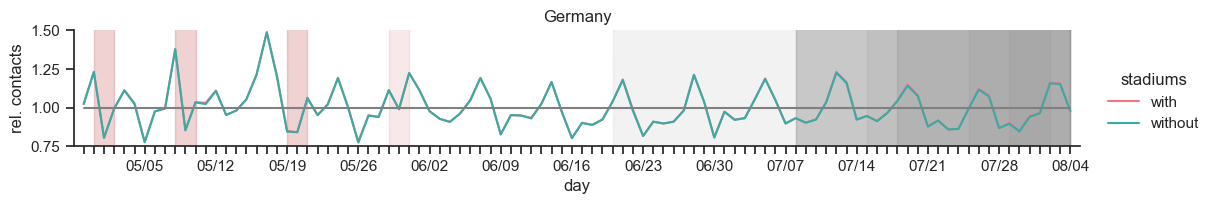

In [20]:
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.husl_palette(2)#sns.color_palette("rocket_r")

city_list = sorted(set(list(aid2city.values()))) #set(data_here.city)

# Plot the lines on two facets
g = sns.relplot(
    data=data_here4,
    x="day", y="to_baseline_unique",
    hue="with_stadiums", hue_order=[True,False],
    kind="line", palette=palette,# size_order=[False, True], 
    height=2, aspect=5.5, facet_kws=dict(sharex=False),
)

axes = g.axes
holis = [date(2024,5,1), date(2024,5,9), date(2024,5,20)]
for ax_row, city in zip(axes, ['Germany']):
    for ax in ax_row:
        ax.set_ylabel('rel. contacts')
        ax.plot([data_here.day.min(), data_here.day.max()], [1,1], c='gray')
        ax.set_title(city)
        ax.set_xticks(list(set(data_here.day)))
        ax.set_xticklabels([str(d.month).zfill(2)+'/'+str(d.day).zfill(2) if d.weekday()==6 else '' for d in list(set(data_here.day))])#, rotation=90)
        #lower = set(data_here.city)
        #ax.fill_between([data_here.day.min(), data_here.day.max()], [1,1]
        matches_here = match_data[match_data.city==city]
        for day, match in zip(matches_here.day, matches_here.match):
            if day >= data_here4.day.min() and day <= data.day.max():
                ax.text(day, 3., match, rotation=90, ha='center', va='top')
        #day_start = vac_data[vac_data.city==city].day_start.iloc[0]
        #day_end = min(vac_data[vac_data.city==city].day_end.iloc[0], data.day.max())
        #if day_end > day_start:
        #    ax.fill_between([day_start, day_end], [0]*2, [3]*2, color='gray', alpha=.25)
        ax.set_ylim([.75, 1.5])
        ax.set_xlim([di-timedelta(1), df+timedelta(1)])

        for holi in holis:
            ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [3]*2, color='C3', alpha=.25)
        #if city in ['Frankfurt am Main','München','Köln','Düsseldorf','Dortmund','Gelsenkirchen','Stuttgart']:
        holi = date(2024,5,30)
        ax.fill_between([holi-timedelta(1), holi+timedelta(1)], [0]*2, [3]*2, color='C3', alpha=.25*.5)

for city in set(vac_data.city):
    day_start = vac_data[vac_data.city==city].day_start.iloc[0]
    day_end = min(vac_data[vac_data.city==city].day_end.iloc[0], data_here4.day.max())
    if day_end > day_start:
        ax.fill_between([day_start, day_end], [0]*2, [ylimup]*2, color='gray', alpha=.1)

lg = g._legend
lg.set_title('stadiums')
for tx in lg.texts:
    if tx.get_text() == 'True':
        tx.set_text('with')
    elif tx.get_text() == 'False':
        tx.set_text('without')

plt.savefig(f'plots/figs1/contacts_baseline_cmp_unique_germany_nowd.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/figs1/contacts_baseline_cmp_unique_germany_nowd.pdf', bbox_inches='tight')
plt.show()